# Modelagem de Tópicos com LDA, NMF e SVD
Neste notebook, vamos explorar a modelagem de tópicos utilizando três algoritmos diferentes: Latent Dirichlet Allocation (LDA), Non-negative Matrix Factorization (NMF), e Singular Value Decomposition (SVD). Nosso objetivo é encontrar o melhor valor de \( k \) (número de tópicos) para cada um desses algoritmos, utilizando métricas específicas a cada um. Por fim, vamos comparar os resultados de cada modelo.


In [11]:
# Libraries

import warnings

warnings.filterwarnings('ignore')
import re
import numpy as np
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, Nmf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from ulteis import preprocess

## Preparar dados 
Por essa parte ser repetitiva não iremos detalhar muito, em resumo aplicamos preprocessamento já definido e uma vez que usaremos a biblioteca Gensim teremos que preparar os dados para se adequar ao padrão que a biblioteca aceita.

In [4]:
bbc_df = pd.read_csv("../data/bbc_data.csv")

text_df = bbc_df["data"].apply(preprocess)
labels_df = bbc_df["labels"]

# Lista com todas as palavras de todos os textos
texts_topics = [word.split() for word in text_df] 
# Criando um dicionário, associa cada palavra a um id
id2word = corpora.Dictionary(texts_topics)
# Lista de tuplas (id, frequência) para todas as palavras.
corpus = [id2word.doc2bow(text) for text in texts_topics]

# Exemplo
print(corpus[222], "\n")
# Exemplo mapeado
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:222]])

[(4, 2), (39, 1), (40, 2), (67, 2), (70, 1), (85, 4), (90, 2), (95, 1), (106, 1), (112, 2), (119, 1), (133, 1), (138, 2), (142, 4), (143, 3), (148, 1), (153, 4), (161, 4), (168, 1), (175, 4), (178, 11), (185, 1), (194, 1), (233, 1), (244, 1), (246, 1), (250, 1), (258, 1), (272, 1), (276, 1), (281, 1), (282, 2), (289, 1), (296, 1), (299, 3), (304, 1), (319, 1), (327, 1), (334, 1), (343, 1), (348, 1), (352, 1), (363, 1), (371, 1), (377, 1), (384, 4), (386, 1), (387, 1), (388, 3), (398, 1), (399, 2), (400, 2), (401, 2), (402, 2), (408, 1), (424, 1), (426, 1), (427, 2), (430, 1), (431, 2), (436, 1), (437, 4), (441, 1), (478, 1), (483, 1), (509, 2), (512, 1), (514, 1), (524, 1), (600, 1), (623, 1), (632, 2), (634, 1), (674, 2), (723, 1), (736, 1), (749, 5), (776, 1), (830, 1), (848, 1), (859, 1), (893, 1), (894, 1), (909, 1), (922, 1), (923, 1), (928, 1), (934, 1), (957, 1), (959, 1), (993, 5), (994, 1), (995, 5), (996, 3), (1011, 1), (1013, 1), (1034, 1), (1040, 1), (1083, 1), (1099, 1), (

## Modelagem de Tópicos com LDA

O **Latent Dirichlet Allocation (LDA)** é um modelo probabilístico que identifica tópicos em um conjunto de documentos, assumindo que cada documento é composto por uma mistura de tópicos, e cada tópico é uma distribuição de palavras.

### Coerência de Tópicos
Mede a qualidade dos tópicos verificando se as palavras dentro de cada tópico fazem sentido juntas. Tópicos com alta coerência têm palavras semanticamente relacionadas, tornando os tópicos mais interpretáveis.

### Perplexidade
Avalia o quão bem o modelo se ajusta aos dados, com valores mais baixos indicando um melhor ajuste. No entanto, pode não refletir diretamente a qualidade interpretável dos tópicos, exigindo um equilíbrio com a coerência.


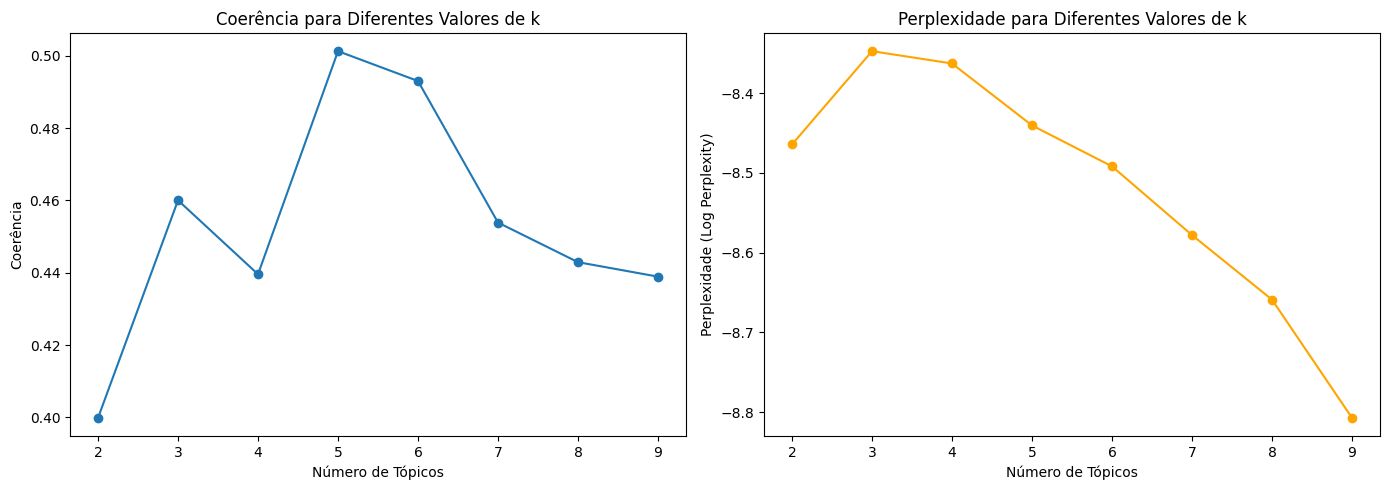

In [14]:
# Função para treinar o modelo e computar valores de correlação e perplexi
def compute_coherence_values(dictionary, corpus, texts, list_range):
    coherence_values = []
    perplexity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo LDA
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        # Calculando a coerência
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        # Calculando a perplexidade
        perplexity_values.append(model.log_perplexity(corpus))
    
    return coherence_values, perplexity_values


# Plotagem 
list_range = [2,3,4,5,6,7,8,9]
coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts_topics, list_range=list_range)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot coherence values
ax1.plot(list_range, coherence_values, marker='o')
ax1.set_title('Coerência para Diferentes Valores de k')
ax1.set_xlabel('Número de Tópicos')
ax1.set_ylabel('Coerência')

# Plot perplexity values
ax2.plot(list_range, perplexity_values, marker='o', color='orange')
ax2.set_title('Perplexidade para Diferentes Valores de k')
ax2.set_xlabel('Número de Tópicos')
ax2.set_ylabel('Perplexidade (Log Perplexity)')

# Show the plots
plt.tight_layout()
plt.show()

### Análise dos Resultados do LDA
Com base no gráfico de coerência, podemos selecionar o valor de \( k \) = 5 que maximiza a coerência dos tópicos. Também consideraremos a **perplexidade** para refinar a escolha de \( k \) = 5.


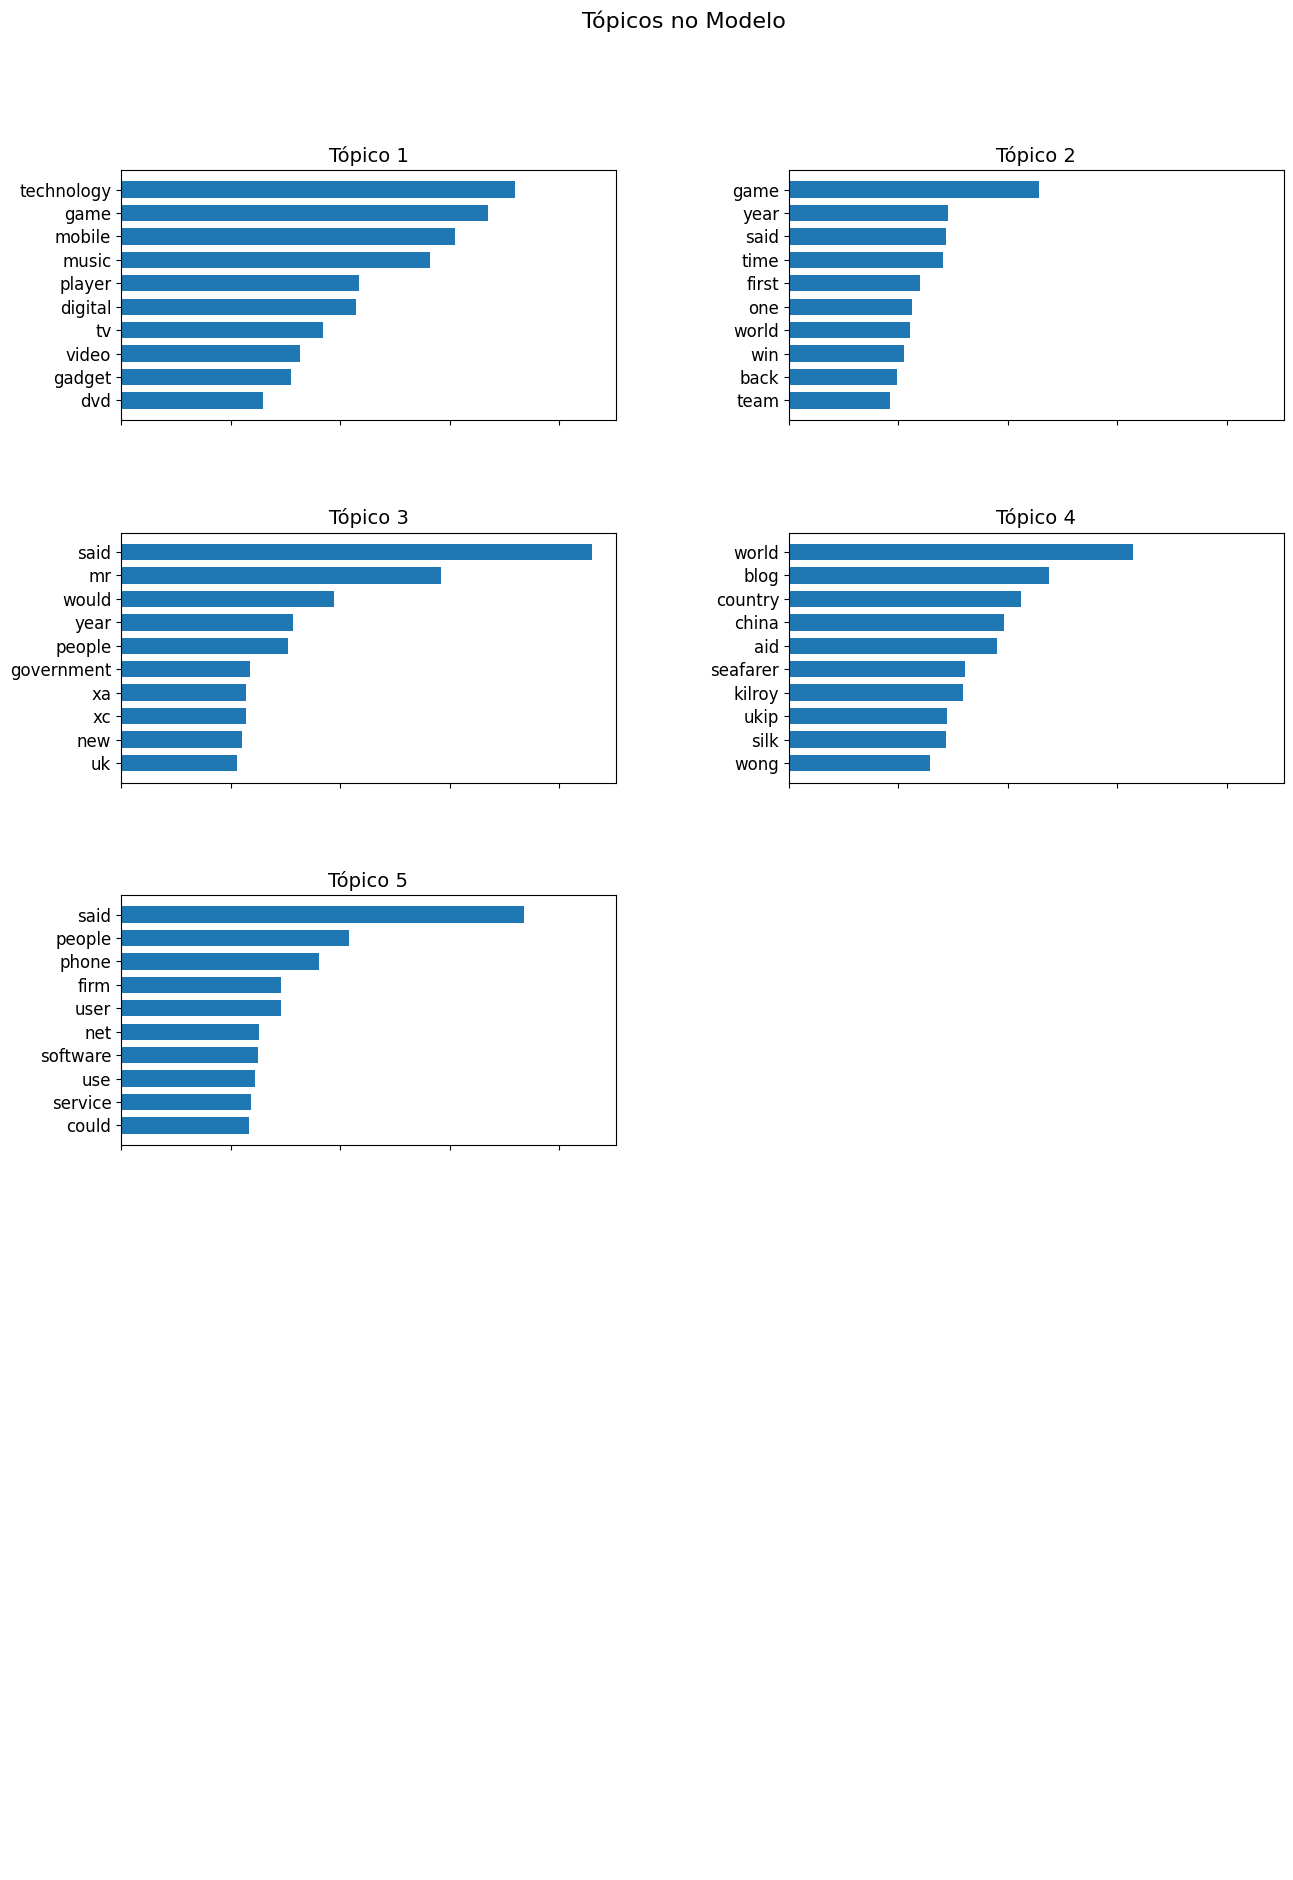

In [17]:
def plot_lda_topics(model, num_topics, num_words=10):
    fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            topic_words = model.show_topic(i, num_words)
            words, weights = zip(*topic_words)
            ax.barh(words, weights, height=0.7)
            ax.set_title(f'Tópico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'Tópicos no Modelo', fontsize=16)
    plt.show()
    
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, 
                         update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
plot_lda_topics(lda, 5)

## Modelagem de Tópicos com NMF

O **Non-negative Matrix Factorization (NMF)** é um algoritmo de decomposição matricial que fatoriza a matriz de documentos em duas outras matrizes: uma que representa os tópicos e outra que representa a associação entre documentos e tópicos. Todos os valores gerados são não-negativos, o que facilita a interpretação dos tópicos.

Para validar o melhor número de tópicos \( k \), vamos utilizar duas métricas principais:

### 1. Sparsidade (Sparsity)
A **sparsidade** mede a quantidade de valores zero nas matrizes resultantes do NMF. Quanto maior a sparsidade, mais esparsa será a matriz, o que significa que cada tópico será composto por poucas palavras e cada documento estará associado a poucos tópicos.

**Interpretação**: Tópicos com alta sparsidade são mais facilmente interpretáveis, pois cada tópico será composto por um número reduzido de palavras-chave. Isso facilita a compreensão do que o tópico representa.

**Objetivo**: O valor ideal de \( k \) deve maximizar a sparsidade, mantendo os tópicos úteis e interpretáveis.

### 2. Erro de Reconstrução (Reconstruction Error)
O **erro de reconstrução** mede a diferença entre a matriz original de documentos e a matriz reconstruída a partir dos tópicos gerados pelo NMF.

**Interpretação**: Um erro de reconstrução menor significa que a decomposição NMF está capturando bem as informações presentes na matriz original. No entanto, valores muito baixos de erro podem resultar em overfitting (muitos tópicos irrelevantes).

**Objetivo**: O valor de \( k \) ideal deve minimizar o erro de reconstrução, garantindo que o modelo capture a estrutura dos dados sem gerar tópicos desnecessários.

Ao balancear essas duas métricas, podemos encontrar o número \( k \) de tópicos que gera a melhor decomposição, com tópicos interpretáveis e uma boa reconstrução da matriz original.


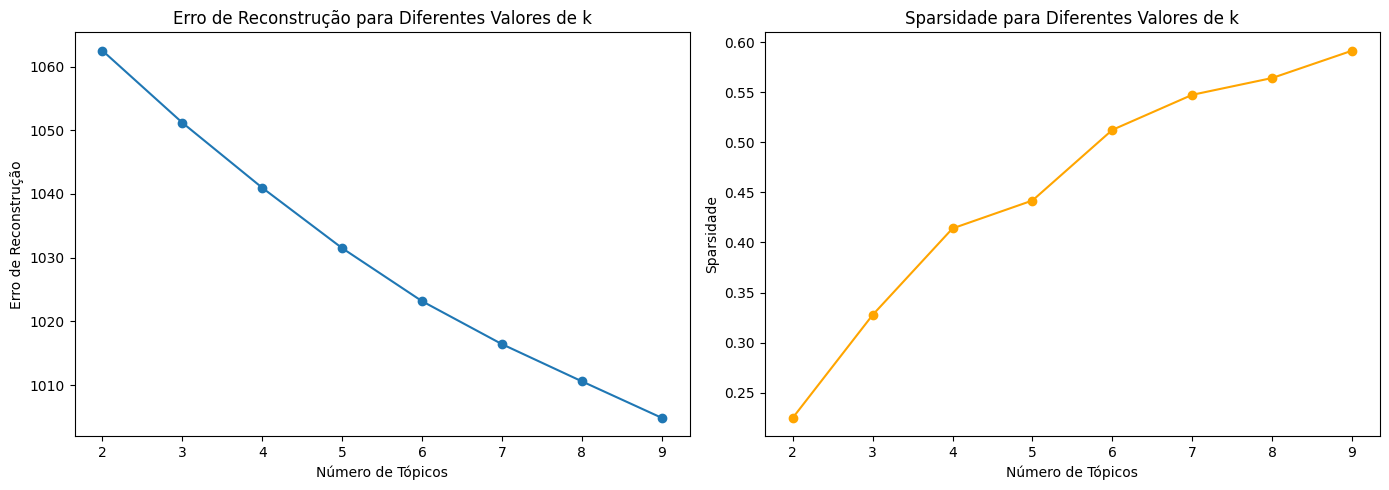

In [14]:
cv = CountVectorizer()
X = cv.fit_transform(text_df)

# Função para calcular o erro de reconstrução e a sparsidade
def compute_nmf_metrics(X, list_range):
    reconstruction_errors = []
    sparsity_values = []
    
    for num_topics in list_range:
        # Treinando o modelo NMF com Scikit-learn
        nmf = NMF(n_components=num_topics, random_state=100, init='nndsvd', max_iter=200)
        W = nmf.fit_transform(X)
        H = nmf.components_
        
        # Calculando o erro de reconstrução
        reconstruction_error = np.linalg.norm(X - np.dot(W, H), 'fro')
        reconstruction_errors.append(reconstruction_error)
        
        # Calculando a sparsidade
        sparsity = (np.count_nonzero(W) + np.count_nonzero(H)) / (W.size + H.size)
        sparsity_values.append(1 - sparsity)  # Invertendo para valores maiores representarem maior sparsidade
    
    return reconstruction_errors, sparsity_values

# Lista de valores de k (número de tópicos)
list_range = [2, 3, 4, 5, 6, 7, 8, 9]

# 2. Calcular os valores de erro de reconstrução e sparsidade
reconstruction_errors, sparsity_values = compute_nmf_metrics(X, list_range)

# 3. Plotar os gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotar Erro de Reconstrução
ax1.plot(list_range, reconstruction_errors, marker='o')
ax1.set_title('Erro de Reconstrução para Diferentes Valores de k')
ax1.set_xlabel('Número de Tópicos')
ax1.set_ylabel('Erro de Reconstrução')

# Plotar Sparsidade
ax2.plot(list_range, sparsity_values, marker='o', color='orange')
ax2.set_title('Sparsidade para Diferentes Valores de k')
ax2.set_xlabel('Número de Tópicos')
ax2.set_ylabel('Sparsidade')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

### Análise dos Resultados do NMF
Com base nas observações dos gráficos:𝑘 = 5 ou 𝑘 = 6 pode ser um bom valor para o número de tópicos. Isso ocorre porque, a partir desses valores, a redução no erro de reconstrução começa a se estabilizar, e a sparsidade aumenta a um nível que ainda permite uma boa interpretabilidade dos tópicos.


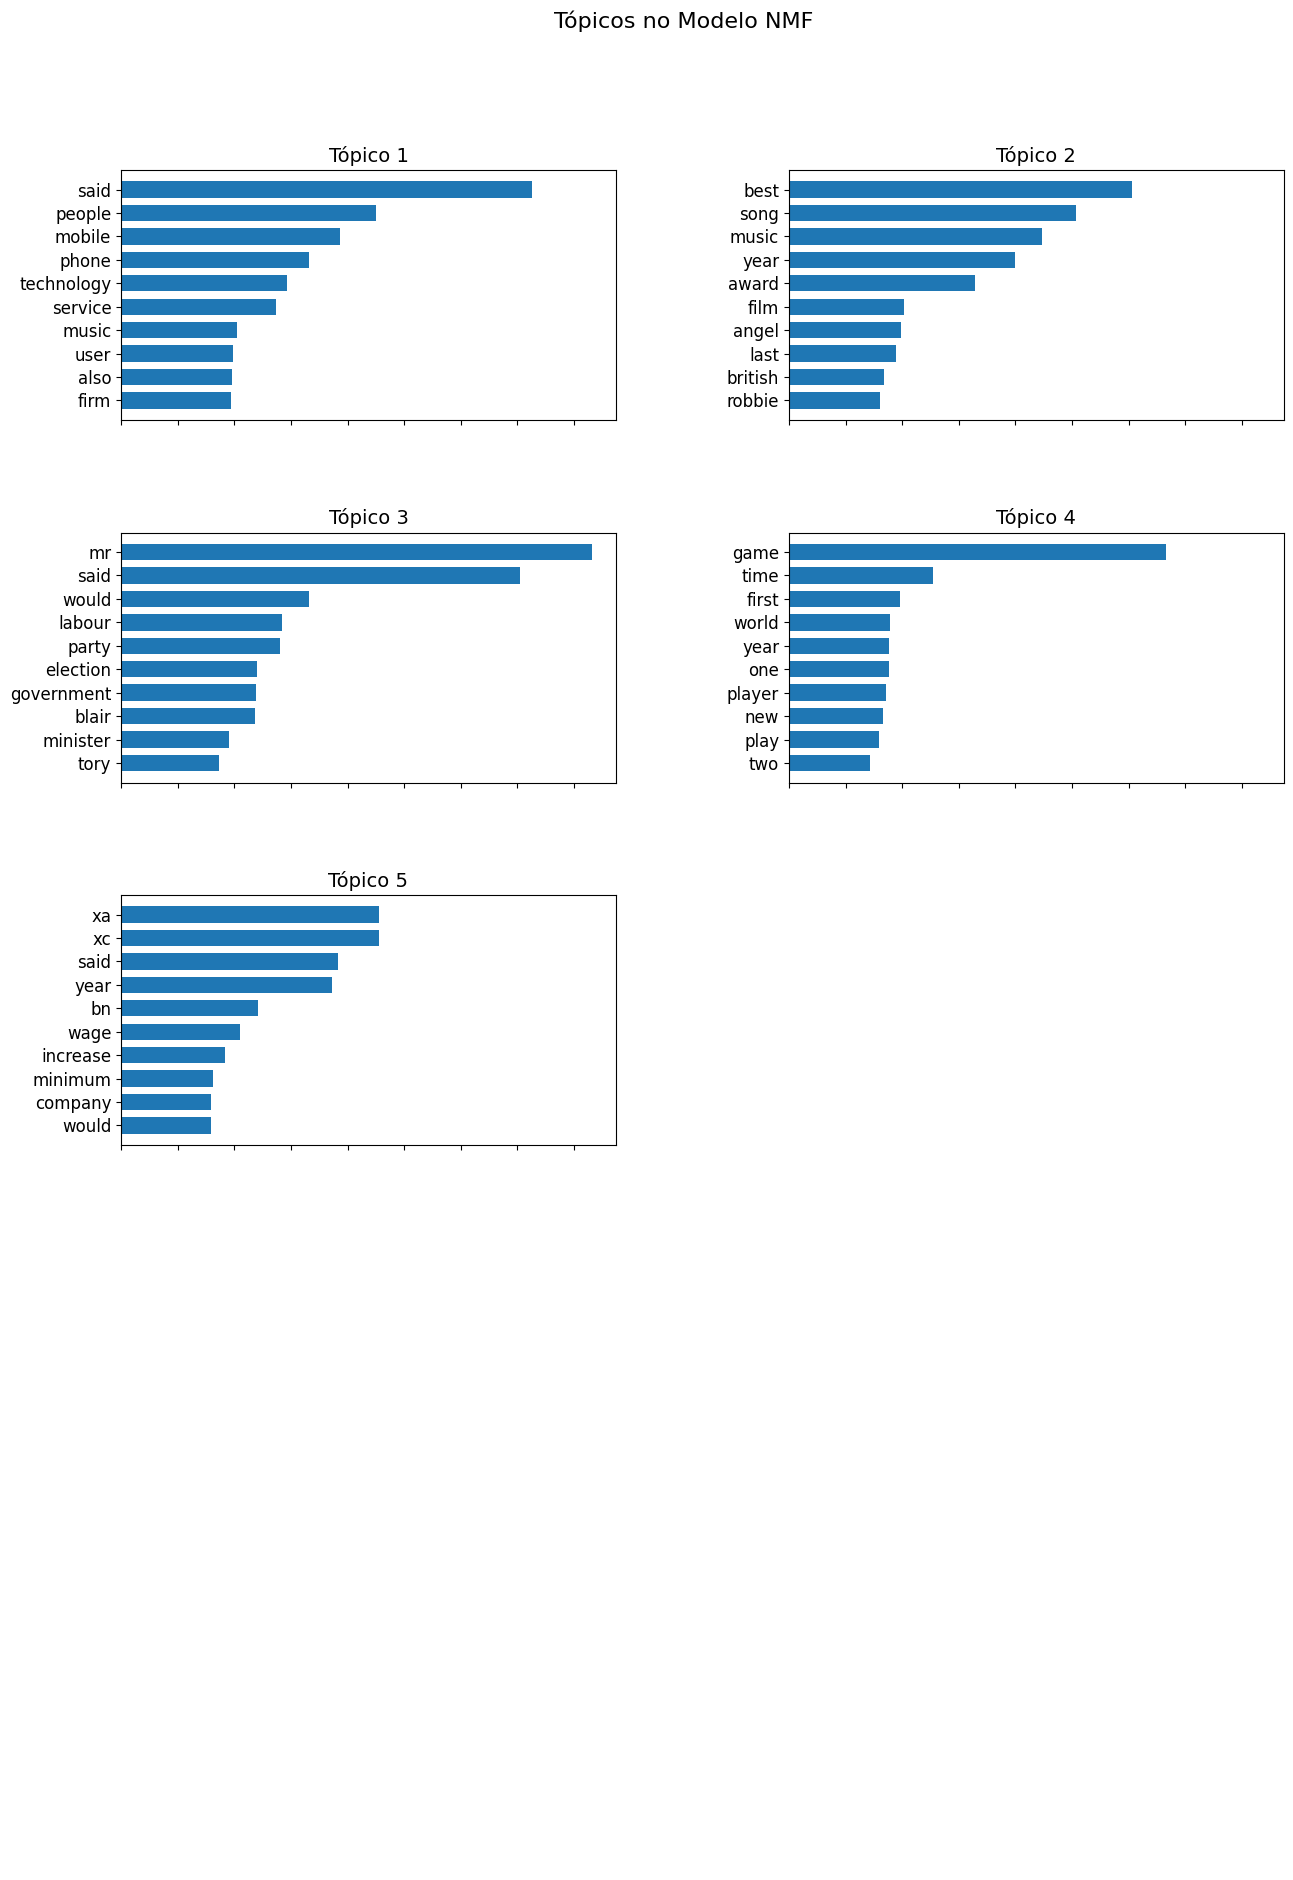

In [20]:
# Função para exibir os tópicos
def plot_nmf_topics(model, feature_names, num_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_topics:
            # Obtendo os índices das palavras mais importantes para cada tópico
            top_words_idx = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [feature_names[idx] for idx in top_words_idx]
            top_weights = model.components_[i][top_words_idx]

            # Plotando os tópicos
            ax.barh(top_words, top_weights, height=0.7)
            ax.set_title(f'Tópico {i+1}', fontsize=14)
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=12)
        else:
            ax.axis('off')

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.35, hspace=0.45)
    plt.suptitle(f'Tópicos no Modelo NMF', fontsize=16)
    plt.show()

# Chamando a função para plotar os tópicos
feature_names = cv.get_feature_names_out()  # Obtendo os nomes das palavras do CountVectorizer ou TfidfVectorizer
nmf = NMF(n_components=5, random_state=100, init='nndsvd', max_iter=200)
nmf.fit_transform(X)
plot_nmf_topics(nmf, feature_names, num_words=10)



## Modelagem de Tópicos com SVD
O **Singular Value Decomposition (SVD)** é uma técnica de fatoração matricial. Vamos utilizar a **variância explicada** e **validação cruzada** para definir o número ideal de componentes \( k \).


### Análise dos Resultados do SVD
Aqui analisamos a **variância explicada** para identificar o número ideal de componentes. Um valor de \(k\) que explica uma alta porcentagem da variância é geralmente o melhor ponto de corte.


## Comparação Final e Conclusão
Após realizar a modelagem de tópicos com os algoritmos **LDA**, **NMF**, e **SVD**, observamos as diferenças entre cada método:

- **LDA**: Gera tópicos probabilísticos com uma interpretação semântica clara. O número de tópicos \(k\) foi otimizado com base na coerência de tópicos.
- **NMF**: Utilizou o erro de reconstrução como métrica principal. O NMF é eficaz para gerar tópicos esparsos e interpretáveis.
- **SVD**: Baseado na variância explicada, o SVD é útil para redução de dimensionalidade, mas pode não ser tão interpretável quanto LDA ou NMF.

Cada método tem suas vantagens e desvantagens. O LDA é mais adequado quando a semântica dos tópicos é importante, enquanto o NMF pode ser mais eficaz quando a interpretação esparsa é desejada. O SVD é uma ferramenta poderosa para análise quantitativa.
